In [1]:
from pymatgen.io.vasp.outputs import Vasprun
import numpy as np
import os
import glob
from pymatgen.electronic_structure.core import Spin

In [2]:
def BZ_avg(eigenvalues, band_index,kpoints,kpoints_weights):
    """
    :param eigenvalues: eigenvalues of all bands with the format of Vasprun.eigenvalues
    :param band_index: the band index for averaging
    :param kpoints: sampled k-points
    :param kpoints_weights: the weights of sampled k-points
    :return: the average of a particular band over k-points in the BZ
    """
    energy_array = [ eigenvalues[Spin.up][k_point_index][band_index][0] for k_point_index in range(len(kpoints))]
    return np.average(energy_array, weights=kpoints_weights)

In [3]:
def Branch_point_energy(vr, vb_sampling_num, cb_sampling_num, scissor):
    """
    Calculate the Branch_point_energy with the formula proposed in:
    APPLIED PHYSICS LETTERS 94, 012104 2009 ; doi: 10.1063/1.3059569

    :param vr: Vasprun Object
    :param cb_sampling_num: the number of cb for sampling. Default vb_sampling_num = 2* cb_sampling_num
    :return:
    """
    #vb_sampling_num = 2*cb_sampling_num
    vbm_band_index = len(list(filter(lambda u:u[1]!=0, vr.eigenvalues[Spin.up][0])))-1

    vb_sampling_indexes = [vbm_band_index-i for i in range(vb_sampling_num)]
    cb_sampling_indexes = [vbm_band_index+i+1 for i in range(cb_sampling_num)]
    

    vb_avg = sum([BZ_avg(vr.eigenvalues,vb_index,vr.actual_kpoints,vr.actual_kpoints_weights)
               for vb_index in vb_sampling_indexes])/len(vb_sampling_indexes)
    cb_avg = sum([BZ_avg(vr.eigenvalues,cb_index,vr.actual_kpoints,vr.actual_kpoints_weights)
               for cb_index in cb_sampling_indexes])/len(cb_sampling_indexes) + scissor
    
    return np.mean([vb_avg,cb_avg])

In [4]:
gap_dict = {}
with open('/Users/yao/Desktop/band offset/gap.csv') as f:
    for line in f:
        gap_dict[line.split(',')[0]] = float(line.split(',')[1])

In [68]:
kpoints = [30, 100, 300, 1000]
ebp_list = []
vbm_list = []
cbm_list = []
bandgap_list = []
kppa_list = []
folder = '/Users/yao/Google Drive/data/semiconductor/DOS-ktest/'
compound = 'ZnO'

for k in kpoints:             
    currentfolder = folder + '/' + compound + '-k' + str(k)
    vr = Vasprun(os.path.join(currentfolder,'vasprun.xml'))
    bandgap = vr.eigenvalue_band_properties[0]
    #scissor = gap_dict[compound] - bandgap
    vbm = vr.eigenvalue_band_properties[2]
    cbm = vr.eigenvalue_band_properties[1] #+ scissor
    ebp = Branch_point_energy(vr, vb_sampling_num=1, cb_sampling_num=1, scissor = 0)
    #ebp_vbm = ebp-vbm
    ebp_list.append(ebp)
    vbm_list.append(vbm)
    cbm_list.append(cbm)
    bandgap_list.append(bandgap)
    x = vr.kpoints.kpts[0][0]
    y = vr.kpoints.kpts[0][1]
    z = vr.kpoints.kpts[0][2]
    no_sites = vr.final_structure.num_sites
    kppa = x*y*z*no_sites
    kppa_list.append(kppa)
    
folder_BS = '/Users/yao/Google Drive/data/semiconductor/DOS-BS/ZnO/vasprun.xml'
vr = Vasprun(folder_BS)  
bandgap = vr.eigenvalue_band_properties[0]
vbm = vr.eigenvalue_band_properties[2]
cbm = vr.eigenvalue_band_properties[1]
#ebp = ebp - vbm

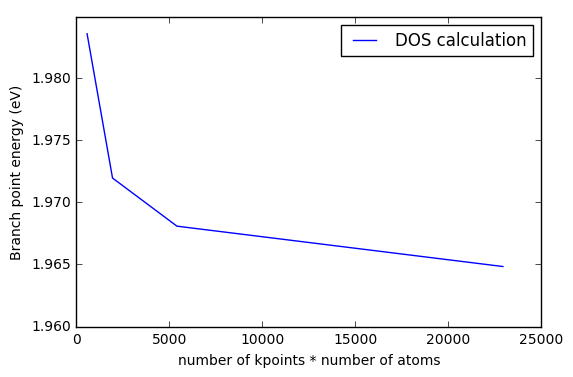

In [73]:
import matplotlib.pyplot as plt
plt.plot(kppa_list, ebp_list, label = 'DOS calculation')
plt.xlabel('number of kpoints * number of atoms')
plt.ylabel('Branch point energy (eV)')
#plt.axhline(y=bandgap, xmin=0, xmax=1, color = 'r', label = 'Band calculation')
plt.legend()
plt.savefig('/Users/yao/Desktop/band offset/ebp2.pdf', dpi=300, format='pdf')
plt.show()